In [1]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os
from pandas import DataFrame
import pandas as pd
from __future__ import (absolute_import, division, print_function)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pyplot
from shapely import wkt
from shapely.geometry import Polygon, MultiPolygon
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
import scipy.stats as stats
from scipy.stats import logistic
from scipy.stats import pearsonr
from numpy import mean
from numpy import std
import mapclassify
import math
import statistics

In [2]:
credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result
    
db, conn = pgconnect(credentials)

Connected successfully.


In [3]:
srid = 4283
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [92]:
BusinessStats = pd.read_csv('BusinessStats.csv').fillna(0).drop_duplicates()

In [93]:
conn.execute("DROP TABLE IF EXISTS business_stats")
business_stats = """CREATE TABLE IF NOT EXISTS business_stats (
                         area_id                                 INT,
                         area_name                               VARCHAR(50) NOT NULL,
                         number_of_businesses                    INT,
                         accommodation_and_food_services_count   INT,
                         retail_trade_count                      INT,
                         agriculture_forestry_and_fishing_count  INT,
                         health_care_and_social_assistance_count INT,
                         public_administration_and_safety_count  INT,
                         transport_postal_and_warehousing_count  INT
                   )"""

conn.execute(business_stats)

table_name = 'business_stats'
BusinessStats.to_sql(table_name, con=conn, if_exists='replace', index=False)

query(conn, 'SELECT * FROM business_stats')

,area_id,area_name,number_of_businesses,accommodation_and_food_services,retail_trade,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,26,27,280,11,0,35
1,101021008,Karabar,326,7,10,8,11,0,43
2,101021009,Queanbeyan,724,52,47,11,56,3,77
3,101021010,Queanbeyan - East,580,16,23,4,12,0,57
4,101021011,Queanbeyan Region,1642,39,63,292,34,7,81
...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,3,0,0,0,0,0
2298,901031003,Jervis Bay,6,0,3,0,0,0,0
2299,901041004,Norfolk Island,0,0,0,0,0,0,0


In [94]:
NH = pd.read_csv('Neighbourhoods.csv', thousands=',')
NH = NH.drop(columns = 'Unnamed: 0').fillna(0).drop_duplicates()
NH.rename(columns = {"0-4":"age_stage1","5-9":"age_stage2","10-14":"age_stage3","15-19":"age_stage4"},inplace = True)
NH["young_people"] = NH["age_stage1"] + NH["age_stage2"] + NH["age_stage3"] + NH["age_stage4"]

In [95]:
conn.execute("DROP TABLE IF EXISTS neighbour_hoods")
neighbour_hoods = """CREATE TABLE IF NOT EXISTS neighbour_hoods (
                         area_id                           INT,
                         area_name                         TEXT NOT NULL,
                         land_area                         FLOAT,
                         population                        INT,
                         number_of_dwellings               INT,
                         number_of_businesses              FLOAT,
                         median_annual_household_income    FLOAT,
                         avg_monthly_rent                  FLOAT,
                         age_0_4                           INT, 
                         age_5_9                           INT,
                         age_10_14                         INT,
                         age_15_19                         INT,
                         young_people                      INT
                   )"""

conn.execute(neighbour_hoods)

table_name = 'neighbour_hoods'
NH.to_sql(table_name, con=conn, if_exists='replace', index=False)

query(conn, 'SELECT * FROM neighbour_hoods')

,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent,age_stage1,age_stage2,age_stage3,age_stage4,young_people
0,102011028,Avoca Beach - Copacabana,643.8000,7590.0,2325,738.0,46996.0,1906.0,467,583,604,560,2214
1,102011029,Box Head - MacMasters Beach,3208.6000,10986.0,3847,907.0,42621.0,1682.0,586,696,661,692,2635
2,102011030,Calga - Kulnura,76795.1000,4841.0,1575,1102.0,42105.0,1182.0,220,254,304,320,1098
3,102011031,Erina - Green Point,3379.3000,14237.0,4450,1666.0,43481.0,1595.0,695,778,916,838,3227
4,102011032,Gosford - Springfield,1691.2000,19385.0,6373,2126.0,45972.0,1382.0,1200,1079,963,977,4219
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931.0,3281,673.0,73164.0,1080.0,432,590,577,527,2126
318,106011113,Singleton Region,4067.2349,4919.0,2055,698.0,87984.0,1000.0,310,394,353,323,1380
319,111021218,Morisset - Cooranbong,330.5208,14959.0,6298,1154.0,58084.0,1260.0,813,855,828,962,3458
320,114021285,Hill Top - Colo Vale,174.3752,6025.0,2249,400.0,81120.0,1512.0,443,500,470,451,1864


In [96]:
data_path = './SA2_2016_AUST'
sa2 = gpd.read_file(os.path.join(data_path, 'SA2_2016_AUST.shp'))
sa2 = sa2[sa2["GCC_NAME16"] == "Greater Sydney"]

In [97]:
conn.execute("DROP TABLE IF EXISTS sa2")
sa2_schema = """CREATE TABLE IF NOT EXISTS sa2 (
                         sa2_main16                    INT,
                         sa2_5dig16                    INT,
                         sa2_name16                    TEXT,
                         sa3_code16                    INT,
                         sa3_name16                    TEXT,
                         sa4_code16                    INT,
                         sa4_name16                    TEXT,
                         gcc_code16                    TEXT,
                         gcc_name16                    TEXT,
                         ste_code16                    INT,
                         ste_name16                    TEXT,
                         areasqkm16                    INT,
                         geom                          GEOMETRY(MULTIPOLYGON, 4283)
                   )"""

conn.execute(sa2_schema)

sa2_copy = sa2.copy()
sa2_copy.columns = sa2_copy.columns.map(lambda x:x. lower())
sa2_copy["geom"] = sa2_copy["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
sa2_copy = sa2_copy.drop(columns = "geometry")

table_name = "sa2"
sa2_copy.to_sql(table_name,con=conn,if_exists='append',index=False,dtype={"geom": Geometry("MULTIPOLYGON",srid)})

query(conn, 'SELECT COUNT(*) FROM sa2')

,count
0,312


In [98]:
data_path = './break_and_enter'
break_and_e = gpd.read_file(os.path.join(data_path, 'BreakEnterDwelling_JanToDec2021.shp'))

In [99]:
conn.execute("DROP TABLE IF EXISTS b_and_e")
break_and_e_schema = """CREATE TABLE IF NOT EXISTS b_and_e (
                         objectid                    INT,
                         contour                     FLOAT,
                         density                     TEXT,
                         orig_fid                    INT,
                         shape_leng                  FLOAT,
                         shape_area                  FLOAT,
                         geom                        GEOMETRY(MULTIPOLYGON, 4283)
                   )"""

conn.execute(break_and_e_schema)

break_and_e_copy = break_and_e.copy()
break_and_e_copy.columns = break_and_e_copy.columns.map(lambda x:x. lower())
break_and_e_copy["geom"] = break_and_e_copy["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
break_and_e_copy = break_and_e_copy.drop(columns = "geometry")

table_name = "b_and_e"
break_and_e_copy.to_sql(table_name,con=conn,if_exists='append',index=False,dtype={"geom": Geometry("MULTIPOLYGON",srid)})

query(conn, 'SELECT COUNT(*) FROM b_and_e')

,count
0,2594


In [100]:
srid = 4283
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [101]:
data_path = 'Filming_Permit_Areas'
permit = gpd.read_file(os.path.join(data_path, 'Filming_Permit_Areas.shp'))
permit = permit[['OBJECTID','geometry']]
permit = permit.fillna(0)
permit

,OBJECTID,geometry
0,1,"POLYGON ((151.20837 -33.85359, 151.20842 -33.8..."
1,2,"MULTIPOLYGON (((151.21890 -33.88687, 151.21895..."
2,3,"MULTIPOLYGON (((151.21528 -33.85846, 151.21540..."
3,4,"MULTIPOLYGON (((151.20190 -33.88123, 151.20189..."
4,5,"POLYGON ((151.21559 -33.85616, 151.21567 -33.8..."
...,...,...
715,716,"POLYGON ((151.21642 -33.88044, 151.21638 -33.8..."
716,717,"POLYGON ((151.21602 -33.88011, 151.21598 -33.8..."
717,718,"POLYGON ((151.19007 -33.90827, 151.18998 -33.9..."
718,719,"POLYGON ((151.19611 -33.87329, 151.19592 -33.8..."


In [102]:
conn.execute("DROP TABLE IF EXISTS permit")
permit_schema = """CREATE TABLE IF NOT EXISTS permit (
                         objectid                    INT,
                         geom                        GEOMETRY(MULTIPOLYGON, 4283)
                   )"""

conn.execute(permit_schema)

permit_copy = permit.copy()
permit_copy.columns = permit_copy.columns.map(lambda x:x. lower())
permit_copy["geom"] = permit_copy["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
permit_copy = permit_copy.drop(columns = "geometry")

table_name = "permit"
permit_copy.to_sql(table_name,con=conn,if_exists='append',index=False,dtype={"geom": Geometry("MULTIPOLYGON",srid)})

query(conn, 'SELECT COUNT(*) FROM permit')

,count
0,720


In [103]:
data_path = './school_catchments'
school_p = gpd.read_file(os.path.join(data_path, 'catchments_primary.shp'))
school_s = gpd.read_file(os.path.join(data_path, 'catchments_secondary.shp'))
school_f = gpd.read_file(os.path.join(data_path, 'catchments_future.shp'))

In [104]:
school = pd.concat([school_p, school_s,school_f],axis = 0)
school = school[~school.index.duplicated(keep = 'first')]
school

,USE_ID,CATCH_TYPE,USE_DESC,ADD_DATE,KINDERGART,YEAR1,YEAR2,YEAR3,YEAR4,YEAR5,YEAR6,YEAR7,YEAR8,YEAR9,YEAR10,YEAR11,YEAR12,PRIORITY,geometry
0,2838,PRIMARY,Parklea PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.93564 -33.71612, 150.93715 -33.7..."
1,3943,PRIMARY,Gordon WPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.14085 -33.74463, 151.14113 -33.7..."
2,2404,PRIMARY,Lindfield EPS,20211219,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.18336 -33.74748, 151.18443 -33.7..."
3,4393,PRIMARY,Carlingford WPS,20220223,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((151.04518 -33.77303, 151.04526 -33.7..."
4,4615,PRIMARY,Caddies Ck PS,20181210,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((150.92567 -33.72960, 150.92602 -33.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1661,4383,PRIMARY,E A Southee PS,20200315,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((147.94621 -34.55863, 147.95292 -34.5..."
1662,3275,PRIMARY,Tumbarumba PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((148.12885 -35.60082, 148.23155 -35.6..."
1663,2239,PRIMARY,Jindera PS,20200507,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((146.86148 -35.87511, 146.87402 -35.8..."
1664,3594,PRIMARY,Louth PS,20200604,Y,Y,Y,Y,Y,Y,Y,N,N,N,N,N,N,None,"POLYGON ((145.18403 -29.65805, 145.18434 -29.6..."


In [105]:
conn.execute("DROP TABLE IF EXISTS school")
school_schema = '''CREATE TABLE school (
                          use_id                            INT,
                          catch_type                        TEXT,
                          use_desc                          TEXT,
                          add_date                          INT,
                          kindergart                        VARCHAR(50),
                          year1                             VARCHAR(50),
                          year2                             VARCHAR(50),
                          year3                             VARCHAR(50),
                          year4                             VARCHAR(50),
                          year5                             VARCHAR(50),
                          year6                             VARCHAR(50),
                          year7                             VARCHAR(50),
                          year8                             VARCHAR(50),
                          year9                             VARCHAR(50),
                          year10                            VARCHAR(50),
                          year11                            VARCHAR(50),
                          year12                            VARCHAR(50),
                          priority                          VARCHAR(50),
                          geom                              GEOMETRY(MULTIPOLYGON, 4283))
                     ''' 

conn.execute(school_schema)
school_copy = school.copy()
school_copy.columns = school_copy.columns.map(lambda x:x. lower())
school_copy["geom"] = school_copy["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
school_copy = school_copy.drop(columns = "geometry")

table_name = "school"
school_copy.to_sql(table_name,con=conn,if_exists='append',index=False,dtype={"geom": Geometry("MULTIPOLYGON",srid)})

query(conn, 'SELECT COUNT(*) FROM school')

,count
0,1666


In [106]:
conn.execute('DROP INDEX IF EXISTS idx_sa2_geom')
conn.execute('CREATE INDEX idx_sa2_geom ON sa2 USING gist (geom);')

In [107]:
conn.execute(''' ALTER TABLE neighbour_hoods ADD COLUMN geom geometry(MULTIPOLYGON, 4283)''')

In [108]:
conn.execute('''UPDATE "neighbour_hoods" as n 
                    SET geom = (SELECT geom 
                                  FROM sa2
                                 WHERE sa2_name16 = n.area_name
                    );''') 

In [109]:
conn.execute('DROP INDEX IF EXISTS neigh_geom')
conn.execute('CREATE INDEX neigh_geom ON neighbour_hoods USING GIST (geom)')

In [110]:
crime = '''SELECT (SUM(shape_area)/SUM(land_area)) AS crime, area_id,n.area_name,n.land_area,n.geom 
             FROM sa2 JOIN neighbour_hoods n ON (sa2.sa2_main16 = n.area_id)
                  JOIN b_and_e be ON ST_Contains(n.geom, be.geom)
            WHERE density = 'High Density'
            GROUP BY n.area_id,n.land_area,n.geom,n.area_name
          '''

crime = pd.read_sql_query(crime,conn)
crime

,crime,area_id,area_name,land_area,geom
0,2.030876e-09,102011036,Niagara Park - Lisarow,1673.2,0106000020BB10000001000000010300000001000000BF...
1,2.403427e-10,102011039,Terrigal - North Avoca,1010.7,0106000020BB1000000100000001030000000100000003...
2,2.447223e-08,102011040,Umina - Booker Bay - Patonga,2522.8,0106000020BB10000002000000010300000001000000F5...
3,4.602696e-09,102011042,Woy Woy - Blackwall,1742.3,0106000020BB100000010000000103000000010000007E...
4,2.815577e-08,102021044,Bateau Bay - Killarney Vale,1086.0,0106000020BB10000001000000010300000001000000F0...
...,...,...,...,...,...
99,3.867860e-08,127031522,Casula,707.2,0106000020BB10000001000000010300000001000000AA...
100,1.094702e-08,127031600,Prestons - Edmondson Park,1413.2,0106000020BB10000001000000010300000001000000AE...
101,2.066115e-08,128011529,Gymea - Grays Point,579.8,0106000020BB1000000100000001030000000100000092...
102,1.006215e-08,128011531,Sylvania - Taren Point,607.3,0106000020BB10000001000000010300000001000000F3...


In [111]:
conn.execute("DROP TABLE IF EXISTS crime")
crime_schema = """CREATE TABLE IF NOT EXISTS crime (
                         area_id           INT,
                         area_name         TEXT,
                         geom              GEOMETRY(MULTIPOLYGON, 4283),
                         crime             FLOAT
                   )"""

conn.execute(crime_schema)

table_name = 'crime'
crime.to_sql(table_name, con=conn, index = False, if_exists='replace')

query(conn, 'SELECT COUNT(*) FROM crime')

,count
0,104


In [7]:
score = '''SELECT n.area_id, sc.use_id, n.area_name, n.median_annual_household_income, n.avg_monthly_rent, n.geom,
                   n.young_people, n.population, b.accommodation_and_food_services, b.retail_trade,
                   b.health_care_and_social_assistance, c.crime AS crime
             FROM neighbour_hoods n 
                   LEFT OUTER JOIN business_stats b ON (n.area_id = b.area_id)
                   LEFT OUTER JOIN sa2 s ON (n.area_id = s.sa2_main16)
                   LEFT OUTER JOIN crime c ON(n.area_id = c.area_id)
                   LEFT OUTER JOIN (SELECT geom, use_id FROM school GROUP BY use_id,geom) sc ON (ST_Contains(n.geom, sc.geom))                  
'''

score_data = pd.read_sql_query(score,conn)
column_mean = score_data.mean()
score_data = score_data.fillna(column_mean)
score_data = score_data.replace(np.inf,np.nan)
score_data

/var/folders/vq/j3mhnhs944s_31tp9b9qxs6w0000gn/T/ipykernel_23924/2425395035.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  column_mean = score_data.mean()


,area_id,use_id,area_name,median_annual_household_income,avg_monthly_rent,geom,young_people,population,accommodation_and_food_services,retail_trade,health_care_and_social_assistance,crime
0,102011028,4008.066667,Avoca Beach - Copacabana,46996.0,1906.0,0106000020BB100000010000000103000000010000005E...,2214,7590.0,33,35,60,2.248671e-08
1,102011029,4008.066667,Box Head - MacMasters Beach,42621.0,1682.0,0106000020BB1000000100000001030000000100000000...,2635,10986.0,23,45,43,2.248671e-08
2,102011030,2852.000000,Calga - Kulnura,42105.0,1182.0,0106000020BB1000000200000001030000000100000085...,1098,4841.0,14,43,12,2.248671e-08
3,102011031,4008.066667,Erina - Green Point,43481.0,1595.0,0106000020BB1000000100000001030000000100000041...,3227,14237.0,68,145,179,2.248671e-08
4,102011032,4008.066667,Gosford - Springfield,45972.0,1382.0,0106000020BB100000010000000103000000010000007F...,4219,19385.0,94,167,246,2.248671e-08
...,...,...,...,...,...,...,...,...,...,...,...,...
323,128021538,3822.000000,Sutherland - Kirrawee,53378.0,1809.0,0106000020BB1000000100000001030000000100000089...,4894,21760.0,73,113,127,4.429106e-08
324,128021538,3136.000000,Sutherland - Kirrawee,53378.0,1809.0,0106000020BB1000000100000001030000000100000089...,4894,21760.0,73,113,127,4.429106e-08
325,128021607,4008.066667,Engadine,52667.0,1955.0,0106000020BB100000010000000103000000010000008E...,5176,17424.0,37,69,82,2.248671e-08
326,128021608,4008.066667,Loftus - Yarrawarrah,51243.0,2163.0,0106000020BB10000001000000010300000001000000A1...,2054,7426.0,9,20,25,2.248671e-08


In [113]:
conn.execute("DROP TABLE IF EXISTS score")
score = """CREATE TABLE IF NOT EXISTS score (
                         area_id                           INT,
                         use_id                            FLOAT,
                         area_name                         TEXT,
                         median_annual_household_income    FLOAT,
                         avg_monthly_rent                  FLOAT,
                         young_people                      FLOAT,
                         population                        FLOAT,
                         accommodation_and_food_services   FLOAT, 
                         retail_trade                      FLOAT,
                         health_care_and_social_assistance FLOAT,
                         crime                             FLOAT,
                         geom                              geometry(MULTIPOLYGON, 4283)
                                                    
         )"""

conn.execute(score)


table_name = 'score'
score_data.to_sql(table_name, con=conn, index = False, if_exists='append', dtype = {'geom': Geometry('MULTIPOLYGON', srid)})

query(conn, 'SELECT COUNT(*) FROM score') 

,count
0,328


In [9]:
score_data['school'] = score_data['use_id'].count()/(score_data['young_people']/1000)
score_data['accomm'] = score_data['accommodation_and_food_services']/(score_data['population']/1000) 
score_data['retail'] = score_data['retail_trade']/(score_data['population']/1000) 
score_data['crime'] = score_data['crime']
score_data['health'] = score_data['health_care_and_social_assistance']/(score_data['population']/1000)

In [10]:
score_data 

,area_id,use_id,area_name,median_annual_household_income,avg_monthly_rent,geom,young_people,population,accommodation_and_food_services,retail_trade,health_care_and_social_assistance,crime,school,accomm,retail,health
0,102011028,4008.066667,Avoca Beach - Copacabana,46996.0,1906.0,0106000020BB100000010000000103000000010000005E...,2214,7590.0,33,35,60,2.248671e-08,148.148148,4.347826,4.611331,7.905138
1,102011029,4008.066667,Box Head - MacMasters Beach,42621.0,1682.0,0106000020BB1000000100000001030000000100000000...,2635,10986.0,23,45,43,2.248671e-08,124.478178,2.093574,4.096122,3.914072
2,102011030,2852.000000,Calga - Kulnura,42105.0,1182.0,0106000020BB1000000200000001030000000100000085...,1098,4841.0,14,43,12,2.248671e-08,298.724954,2.891964,8.882462,2.478827
3,102011031,4008.066667,Erina - Green Point,43481.0,1595.0,0106000020BB1000000100000001030000000100000041...,3227,14237.0,68,145,179,2.248671e-08,101.642392,4.776287,10.184730,12.572873
4,102011032,4008.066667,Gosford - Springfield,45972.0,1382.0,0106000020BB100000010000000103000000010000007F...,4219,19385.0,94,167,246,2.248671e-08,77.743541,4.849110,8.614908,12.690224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,128021538,3822.000000,Sutherland - Kirrawee,53378.0,1809.0,0106000020BB1000000100000001030000000100000089...,4894,21760.0,73,113,127,4.429106e-08,67.020842,3.354779,5.193015,5.836397
324,128021538,3136.000000,Sutherland - Kirrawee,53378.0,1809.0,0106000020BB1000000100000001030000000100000089...,4894,21760.0,73,113,127,4.429106e-08,67.020842,3.354779,5.193015,5.836397
325,128021607,4008.066667,Engadine,52667.0,1955.0,0106000020BB100000010000000103000000010000008E...,5176,17424.0,37,69,82,2.248671e-08,63.369397,2.123508,3.960055,4.706152
326,128021608,4008.066667,Loftus - Yarrawarrah,51243.0,2163.0,0106000020BB10000001000000010300000001000000A1...,2054,7426.0,9,20,25,2.248671e-08,159.688413,1.211958,2.693240,3.366550


In [11]:
score_data = score_data.replace(np.inf,np.nan)

In [12]:
score_data["z_school"]=(score_data["school"]-score_data["school"].mean())  \
                                /score_data["school"].std()
score_data['z_school']

0     -0.105356
1     -0.106403
2     -0.098696
3     -0.107413
4     -0.108471
         ...   
323   -0.108945
324   -0.108945
325   -0.109106
326   -0.104846
327   -0.097972
Name: z_school, Length: 328, dtype: float64

In [13]:
score_data["z_accomm"]=(score_data["accomm"]-score_data["accomm"].mean())  \
                                /score_data["accomm"].std()
score_data['z_accomm']

0     -0.117847
1     -0.160578
2     -0.145444
3     -0.109725
4     -0.108345
         ...   
323   -0.136671
324   -0.136671
325   -0.160010
326   -0.177289
327   -0.179664
Name: z_accomm, Length: 328, dtype: float64

In [14]:
score_data["z_retail"]=(score_data["retail"]-score_data["retail"].mean())  \
                                /score_data["retail"].std()
score_data['z_retail']

0     -0.142086
1     -0.145228
2     -0.116036
3     -0.108093
4     -0.117668
         ...   
323   -0.138538
324   -0.138538
325   -0.146058
326   -0.153784
327   -0.150327
Name: z_retail, Length: 328, dtype: float64

In [15]:
score_data["z_crime"]=(score_data["crime"]-score_data["crime"].mean())  \
                                /score_data["crime"].std()
score_data['z_crime']

0      2.154376e-16
1      2.154376e-16
2      2.154376e-16
3      2.154376e-16
4      2.154376e-16
           ...     
323    1.419725e+00
324    1.419725e+00
325    2.154376e-16
326    2.154376e-16
327    2.154376e-16
Name: z_crime, Length: 328, dtype: float64

In [16]:
score_data["z_health"]=(score_data["health"]-score_data["health"].mean())  \
                                /score_data["health"].std()
score_data['z_health']

0      0.072319
1     -0.176405
2     -0.265850
3      0.363213
4      0.370527
         ...   
323   -0.056605
324   -0.056605
325   -0.127042
326   -0.210526
327   -0.234098
Name: z_health, Length: 328, dtype: float64

In [17]:
score_data['score'] = score_data['z_school']+score_data['z_accomm']+score_data['z_retail']-score_data['z_crime']+score_data['z_health']
score_data['score']

0     -0.292970
1     -0.588614
2     -0.626025
3      0.037981
4      0.036044
         ...   
323   -1.860484
324   -1.860484
325   -0.542217
326   -0.646446
327   -0.662062
Name: score, Length: 328, dtype: float64

In [18]:
score_data["liveability_score"] = score_data["score"].map(lambda x:1/(1 + math.exp(-x)))
score_data = score_data[["area_id","use_id","area_name","median_annual_household_income","avg_monthly_rent","liveability_score","geom"]]

score_data 

,area_id,use_id,area_name,median_annual_household_income,avg_monthly_rent,liveability_score,geom
0,102011028,4008.066667,Avoca Beach - Copacabana,46996.0,1906.0,0.427277,0106000020BB100000010000000103000000010000005E...
1,102011029,4008.066667,Box Head - MacMasters Beach,42621.0,1682.0,0.356953,0106000020BB1000000100000001030000000100000000...
2,102011030,2852.000000,Calga - Kulnura,42105.0,1182.0,0.348412,0106000020BB1000000200000001030000000100000085...
3,102011031,4008.066667,Erina - Green Point,43481.0,1595.0,0.509494,0106000020BB1000000100000001030000000100000041...
4,102011032,4008.066667,Gosford - Springfield,45972.0,1382.0,0.509010,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...
323,128021538,3822.000000,Sutherland - Kirrawee,53378.0,1809.0,0.134647,0106000020BB1000000100000001030000000100000089...
324,128021538,3136.000000,Sutherland - Kirrawee,53378.0,1809.0,0.134647,0106000020BB1000000100000001030000000100000089...
325,128021607,4008.066667,Engadine,52667.0,1955.0,0.367672,0106000020BB100000010000000103000000010000008E...
326,128021608,4008.066667,Loftus - Yarrawarrah,51243.0,2163.0,0.343791,0106000020BB10000001000000010300000001000000A1...


In [19]:
column_mean = score_data.mean()
score_data = score_data.fillna(column_mean)
score_data = score_data.replace(np.inf,column_mean)
score_data = score_data[~score_data.index.duplicated(keep = 'first')]
score_data

/var/folders/vq/j3mhnhs944s_31tp9b9qxs6w0000gn/T/ipykernel_23924/3902813822.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  column_mean = score_data.mean()


,area_id,use_id,area_name,median_annual_household_income,avg_monthly_rent,liveability_score,geom
0,102011028,4008.066667,Avoca Beach - Copacabana,46996.0,1906.0,0.427277,0106000020BB100000010000000103000000010000005E...
1,102011029,4008.066667,Box Head - MacMasters Beach,42621.0,1682.0,0.356953,0106000020BB1000000100000001030000000100000000...
2,102011030,2852.000000,Calga - Kulnura,42105.0,1182.0,0.348412,0106000020BB1000000200000001030000000100000085...
3,102011031,4008.066667,Erina - Green Point,43481.0,1595.0,0.509494,0106000020BB1000000100000001030000000100000041...
4,102011032,4008.066667,Gosford - Springfield,45972.0,1382.0,0.509010,0106000020BB100000010000000103000000010000007F...
...,...,...,...,...,...,...,...
323,128021538,3822.000000,Sutherland - Kirrawee,53378.0,1809.0,0.134647,0106000020BB1000000100000001030000000100000089...
324,128021538,3136.000000,Sutherland - Kirrawee,53378.0,1809.0,0.134647,0106000020BB1000000100000001030000000100000089...
325,128021607,4008.066667,Engadine,52667.0,1955.0,0.367672,0106000020BB100000010000000103000000010000008E...
326,128021608,4008.066667,Loftus - Yarrawarrah,51243.0,2163.0,0.343791,0106000020BB10000001000000010300000001000000A1...


In [125]:
conn.execute("DROP TABLE IF EXISTS liveability")
liveability_schema = """CREATE TABLE IF NOT EXISTS liveability (
                         area_id                         INT,
                         use_id                          INT,
                         area_name                       TEXT,
                         median_annual_household_income  FLOAT,
                         avg_monthly_rent                FLOAT,
                         liveability_score               FLOAT,
                         geom                            geometry(MULTIPOLYGON, 4283)
                   )"""

conn.execute(liveability_schema)

table_name = 'liveability'
score_data.to_sql(table_name, con=conn, index = False, if_exists='append', dtype = {'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, 'SELECT COUNT(*) FROM liveability') 

,count
0,328


<AxesSubplot:>

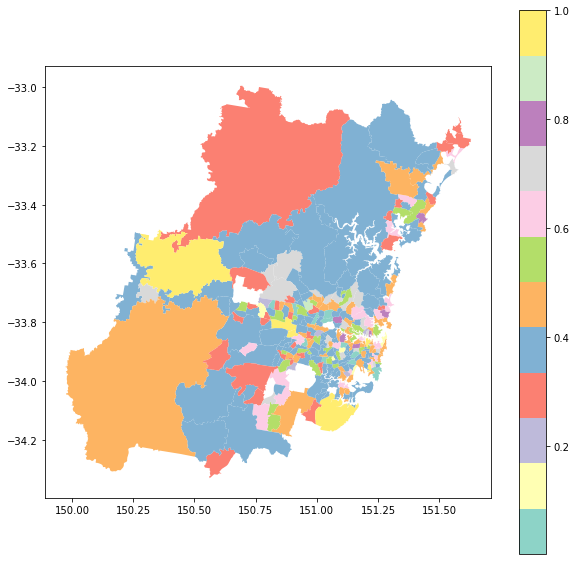

In [127]:
liveability_score = gpd.read_postgis('SELECT * FROM liveability', conn, geom_col='geom')
liveability_score.plot(cmap='Set3', figsize = (10,10), column = 'liveability_score', legend = True)

<AxesSubplot:>

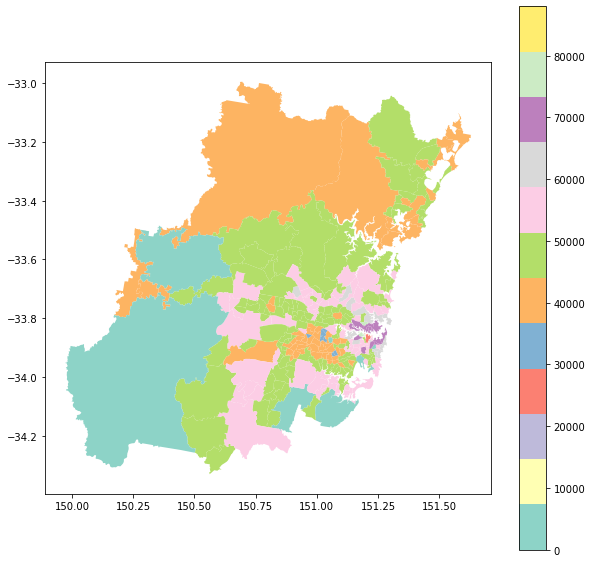

In [4]:
median_income = gpd.read_postgis('SELECT * FROM neighbour_hoods', conn, geom_col='geom')
median_income.plot(cmap='Set3', figsize = (10,10), column = 'median_annual_household_income',legend = True)

<AxesSubplot:>

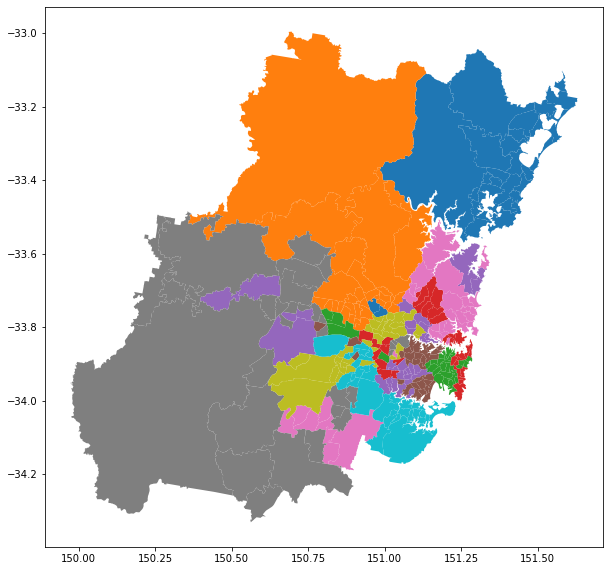

In [5]:
sa2 = gpd.read_postgis('SELECT ST_Transform(geom,4326) AS geom FROM sa2', conn, geom_col='geom')
sa2.plot(cmap='tab10', figsize = (10,10), legend = True)

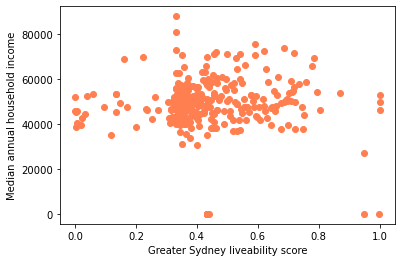

Pearsons correlation: 0.006


In [20]:
pyplot.scatter(score_data['liveability_score'],score_data['median_annual_household_income'], color = 'coral')
pyplot.xlabel('Greater Sydney liveability score')
pyplot.ylabel('Median annual household income')
pyplot.show()

corr, _ = pearsonr(score_data['liveability_score'],score_data['median_annual_household_income'])
print('Pearsons correlation: %.3f' % corr)

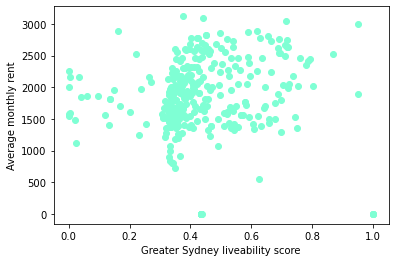

Pearsons correlation: 0.073


In [21]:
pyplot.scatter(score_data['liveability_score'],score_data['avg_monthly_rent'], color = 'aquamarine')
pyplot.xlabel('Greater Sydney liveability score')
pyplot.ylabel('Average monthly rent')
pyplot.show()

corr, _ = pearsonr(score_data['liveability_score'],score_data['avg_monthly_rent'])
print('Pearsons correlation: %.3f' % corr)

In [50]:
new_score = '''SELECT s.sa2_main16, s.sa2_name16, s.areasqkm16, s.geom, n.young_people, n.population, 
                      b.accommodation_and_food_services, b.retail_trade, b.health_care_and_social_assistance, 
                      p.objectid
                 FROM sa2 s
                      LEFT JOIN neighbour_hoods n ON (s.sa2_main16 = n.area_id )
                      LEFT JOIN business_stats b ON (n.area_id = b.area_id)
                      LEFT JOIN permit p ON (ST_Contains(s.geom, p.geom))
                WHERE s.sa3_name16 = 'Sydney Inner City'
'''

new_score_data = pd.read_sql_query(new_score,conn)
new_score_data = new_score_data.fillna(0)
new_score_data = new_score_data.replace(np.inf,np.nan)
new_score_data

,sa2_main16,sa2_name16,areasqkm16,geom,young_people,population,accommodation_and_food_services,retail_trade,health_care_and_social_assistance,objectid
0,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,68.0
1,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,69.0
2,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,70.0
3,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,71.0
4,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,72.0
...,...,...,...,...,...,...,...,...,...,...
444,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,553.0
445,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,554.0
446,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,555.0
447,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,556.0


In [51]:
conn.execute("DROP TABLE IF EXISTS new_score")
new_score = """CREATE TABLE IF NOT EXISTS new_score (
                         sa2_main16                        INT,
                         sa2_name16                        TEXT,
                         areasqkm16                        INT,
                         young_people                      INT,
                         population                        INT,
                         accommodation_and_food_services   INT,
                         retail_trade                      INT,
                         health_care_and_social_assistance INT,
                         objectid                          INT,
                         geom                              geometry(MULTIPOLYGON, 4283)
                                                    
         )"""

conn.execute(new_score)


table_name = 'new_score'
new_score_data.to_sql(table_name, con=conn, index = False, if_exists='append', dtype = {'geom': Geometry('MULTIPOLYGON', srid)})

query(conn, 'SELECT COUNT(*) FROM new_score')

,count
0,449


In [52]:
new_score_data['accomm'] = new_score_data['accommodation_and_food_services']/(new_score_data['population']/1000) 
new_score_data['retail'] = new_score_data['retail_trade']/(new_score_data['population']/1000) 
new_score_data['health'] = new_score_data['health_care_and_social_assistance']/(new_score_data['population']/1000)
new_score_data['permit'] = new_score_data['objectid'].count()/new_score_data['areasqkm16'].sum()

new_score_data = new_score_data.drop_duplicates()
new_score_data

,sa2_main16,sa2_name16,areasqkm16,geom,young_people,population,accommodation_and_food_services,retail_trade,health_care_and_social_assistance,objectid,accomm,retail,health,permit
0,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,68.0,54.337311,54.853273,39.245405,0.372614
1,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,69.0,54.337311,54.853273,39.245405,0.372614
2,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,70.0,54.337311,54.853273,39.245405,0.372614
3,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,71.0,54.337311,54.853273,39.245405,0.372614
4,117031337,Sydney - Haymarket - The Rocks,4,0106000020BB100000030000000103000000010000000E...,2617,31010.0,1685,1701,1217,72.0,54.337311,54.853273,39.245405,0.372614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,553.0,6.090327,8.726832,4.060218,0.372614
445,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,554.0,6.090327,8.726832,4.060218,0.372614
446,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,555.0,6.090327,8.726832,4.060218,0.372614
447,117031338,Waterloo - Beaconsfield,4,0106000020BB10000001000000010300000001000000F7...,5215,37929.0,231,331,154,556.0,6.090327,8.726832,4.060218,0.372614


In [53]:
new_score_data["z_accomm"]=(new_score_data["accomm"]-new_score_data["accomm"].mean())  \
                                /new_score_data["accomm"].std()
new_score_data['z_accomm']

0      2.051142
1      2.051142
2      2.051142
3      2.051142
4      2.051142
         ...   
444   -0.571746
445   -0.571746
446   -0.571746
447   -0.571746
448   -0.571746
Name: z_accomm, Length: 449, dtype: float64

In [54]:
new_score_data["z_retail"]=(new_score_data["retail"]-new_score_data["retail"].mean())  \
                                /new_score_data["retail"].std()
new_score_data['z_retail']

0      2.038976
1      2.038976
2      2.038976
3      2.038976
4      2.038976
         ...   
444   -0.468659
445   -0.468659
446   -0.468659
447   -0.468659
448   -0.468659
Name: z_retail, Length: 449, dtype: float64

In [55]:
new_score_data["z_health"]=(new_score_data["health"]-new_score_data["health"].mean())  \
                                /new_score_data["health"].std()
new_score_data['z_health']

0      1.966374
1      1.966374
2      1.966374
3      1.966374
4      1.966374
         ...   
444   -0.789360
445   -0.789360
446   -0.789360
447   -0.789360
448   -0.789360
Name: z_health, Length: 449, dtype: float64

In [56]:
new_score_data["z_permit"]=(new_score_data["permit"]-new_score_data["permit"].mean())  \
                                /new_score_data["permit"].std()
new_score_data['z_permit']

0      0.998886
1      0.998886
2      0.998886
3      0.998886
4      0.998886
         ...   
444    0.998886
445    0.998886
446    0.998886
447    0.998886
448    0.998886
Name: z_permit, Length: 449, dtype: float64

In [57]:
new_score_data['new_score'] = new_score_data['z_accomm']+new_score_data['z_retail']+new_score_data['z_health']+new_score_data['z_permit']
new_score_data['new_score']

0      7.055379
1      7.055379
2      7.055379
3      7.055379
4      7.055379
         ...   
444   -0.830879
445   -0.830879
446   -0.830879
447   -0.830879
448   -0.830879
Name: new_score, Length: 449, dtype: float64

In [58]:
new_score_data["new_liveability_score"] = new_score_data["new_score"].map(lambda x:1/(1 + math.exp(-x)))
new_score_data=new_score_data[["sa2_main16","sa2_name16","new_liveability_score","geom"]]

new_score_data

,sa2_main16,sa2_name16,new_liveability_score,geom
0,117031337,Sydney - Haymarket - The Rocks,0.999138,0106000020BB100000030000000103000000010000000E...
1,117031337,Sydney - Haymarket - The Rocks,0.999138,0106000020BB100000030000000103000000010000000E...
2,117031337,Sydney - Haymarket - The Rocks,0.999138,0106000020BB100000030000000103000000010000000E...
3,117031337,Sydney - Haymarket - The Rocks,0.999138,0106000020BB100000030000000103000000010000000E...
4,117031337,Sydney - Haymarket - The Rocks,0.999138,0106000020BB100000030000000103000000010000000E...
...,...,...,...,...
444,117031338,Waterloo - Beaconsfield,0.303459,0106000020BB10000001000000010300000001000000F7...
445,117031338,Waterloo - Beaconsfield,0.303459,0106000020BB10000001000000010300000001000000F7...
446,117031338,Waterloo - Beaconsfield,0.303459,0106000020BB10000001000000010300000001000000F7...
447,117031338,Waterloo - Beaconsfield,0.303459,0106000020BB10000001000000010300000001000000F7...


In [59]:
conn.execute("DROP TABLE IF EXISTS new_liveability")
new_liveability_schema = """CREATE TABLE IF NOT EXISTS new_liveability (
                         sa2_main16                      INT,
                         sa2_name16                      TEXT,
                         new_liveability_score           FLOAT,
                         geom                            geometry(MULTIPOLYGON, 4283)
                   )"""

conn.execute(new_liveability_schema)

table_name = 'new_liveability'
new_score_data.to_sql(table_name, con=conn, index = False, if_exists='append', dtype = {'geom': Geometry('MULTIPOLYGON', srid)})
query(conn, 'SELECT COUNT(*) FROM new_liveability') 

,count
0,449


<AxesSubplot:>

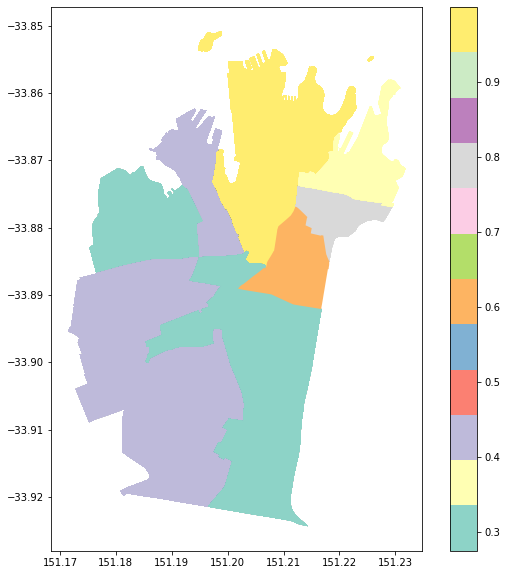

In [60]:
new_liveability_score = gpd.read_postgis('SELECT * FROM new_liveability', conn, geom_col='geom')
new_liveability_score.plot(cmap='Set3', figsize = (10,10), column = 'new_liveability_score', legend = True)

In [60]:
conn.execute(''' ALTER TABLE business_stats ADD CONSTRAINT pk_businessstats_id primary key(area_id)''')

In [62]:
conn.execute(''' ALTER TABLE neighbour_hoods ADD CONSTRAINT pk_neighbour_hoods primary key(area_id)''')

In [63]:
conn.execute(''' ALTER TABLE sa2 ADD CONSTRAINT pk_sa2 primary key(sa2_main16)''')

In [64]:
conn.execute(''' ALTER TABLE b_and_e ADD CONSTRAINT pk_b_and_e primary key(objectid)''')

In [65]:
conn.execute(''' ALTER TABLE greenhouse_gas ADD CONSTRAINT pk_greenhouse_gas primary key(objectid1)''')

In [87]:
conn.execute(''' ALTER TABLE school ADD CONSTRAINT pk_school primary key(use_id)''')

In [67]:
conn.execute(''' ALTER TABLE crime ADD CONSTRAINT pk_crime primary key(area_id)''')

In [68]:
conn.execute(''' ALTER TABLE score ADD CONSTRAINT pk_score primary key(area_id)''')

In [ ]:
conn.execute('''DELETE FROM liveability WHERE area_id IN (124031458,123021438,125021477,123021442,128021538,
                127031524) ''')

In [62]:
conn.execute(''' ALTER TABLE liveability ADD CONSTRAINT pk_liveability primary key(area_id)''')

In [ ]:
conn.execute('''DELETE FROM new_liveability WHERE sa2_main16 IN (117031337,117031329,117031330,117031331,
                 117031332,117031333,117031334,117031335,117031338) ''')

In [81]:
conn.execute(''' ALTER TABLE new_liveability ADD CONSTRAINT pk_new_liveability primary key(sa2_main16)''')

In [ ]:
conn.execute('''DELETE FROM new_score WHERE sa2_main16 IN (117031337,117031329,117031330,117031331,
                 117031332,117031333,117031334,117031335,117031338) ''')

In [85]:
conn.execute(''' ALTER TABLE new_score ADD CONSTRAINT pk_new_score primary key(sa2_main16)''')

In [67]:
conn.close()
db.dispose()